# Basics

In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import pytz


In [2]:
# Adjusting the start and end times
frequency = "1m"
start_time = (datetime.now(pytz.timezone('US/Pacific')) - timedelta(days=365)).strftime('%Y-%m-%d')  # 5 days ago from the current date
end_time = (datetime.now(pytz.timezone('US/Pacific'))- timedelta(days=1)).strftime('%Y-%m-%d')  # Current date in UTC

In [3]:
# Define your tickers, start time, end time, and frequency
tickers = ["BTCC-B.TO"]

# Retrieve historical data and adjust to Pacific Time
historical_data = {}
for ticker in tickers:
    data = yf.download(ticker, start=start_time, end=end_time, interval=frequency)[['High', 'Low', 'Open', 'Close']]
    #data.index = data.index.tz_localize('UTC').tz_convert('US/Pacific')  # Convert timezone to Pacific Time
    historical_data[ticker] = data

# Combine data without weights
combined_data = pd.DataFrame()
for ticker, data in historical_data.items():
    for col in data.columns:
        combined_column_name = f"{ticker}_{col}"  # Create a unique column name for each 'High' and 'Low'
        combined_data[combined_column_name] = data[col]

[*********************100%%**********************]  1 of 1 completed


### Previous Close

### Current Open

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'combined_data' is your DataFrame

# Convert the index to a datetime index if it's not already
combined_data.index = pd.to_datetime(combined_data.index)

# Extract the date from the datetime index
combined_data['date'] = combined_data.index.date

# Extract the first 'BTCC-B.TO_Open' of each day
first_values_daily = combined_data.groupby('date')['BTCC-B.TO_Open'].first()

# Map these first opening values back onto the combined_data DataFrame
# This directly uses the current day's date to fetch the opening price
combined_data['current_day_open'] = combined_data['date'].apply(lambda x: first_values_daily.get(x, np.nan))

# Calculate percent change for each minute against the current day's opening price
combined_data['percent_change'] = (combined_data['BTCC-B.TO_High'] - combined_data['current_day_open']) / combined_data['current_day_open'] * 100

# Drop rows where 'percent_change' is NaN (i.e., potentially the first entries if the opening price is not available)
combined_data.dropna(subset=['percent_change'], inplace=True)

# The DataFrame 'combined_data' now contains the additional columns 'current_day_open' and 'percent_change',
# which represent the opening price of BTCC-B.TO for the current day and the percent change of the high price
# from the opening price for each entry, respectively.


## Analysis

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import skew, kurtosis, normaltest

# Assuming 'combined_data' already has the 'percent_change' column calculated

# Just ensure to drop NaN values from the 'percent_change' column
# This is important to remove the first day's data or any other missing data points
cleaned_percent_changes = combined_data['percent_change'].dropna()

# Calculate the mean and standard deviation of the percent changes
mean_percent_change = np.mean(cleaned_percent_changes)
stddev_percent_change = np.std(cleaned_percent_changes)

# Calculate skewness and kurtosis
skewness = skew(cleaned_percent_changes)
kurtosis_value = kurtosis(cleaned_percent_changes)

# Perform the normality test
normality_test_result = normaltest(cleaned_percent_changes)

# Print the calculated mean, standard deviation, skewness, kurtosis, and normality test results
print(f'Mean of Percent Changes: {mean_percent_change}')
print(f'Standard Deviation of Percent Changes: {stddev_percent_change}')
print(f'Skewness of Percent Changes: {skewness}')
print(f'Kurtosis of Percent Changes: {kurtosis_value}')
print(f'Normality Test Results: Statistic={normality_test_result.statistic:.2f}, P-value={normality_test_result.pvalue:.2e}')

# Interpretation of normality test results
if normality_test_result.pvalue < 0.05:
    print("The distribution of percent changes is not normally distributed (reject H0).")
else:
    print("There is not enough evidence to conclude that the distribution of percent changes is not normally distributed (fail to reject H0).")


Mean of Percent Changes: 0.305454561529385
Standard Deviation of Percent Changes: 1.5686469185118732
Skewness of Percent Changes: 1.8368166009029059
Kurtosis of Percent Changes: 10.32792185680219
Normality Test Results: Statistic=795.74, P-value=1.61e-173
The distribution of percent changes is not normally distributed (reject H0).


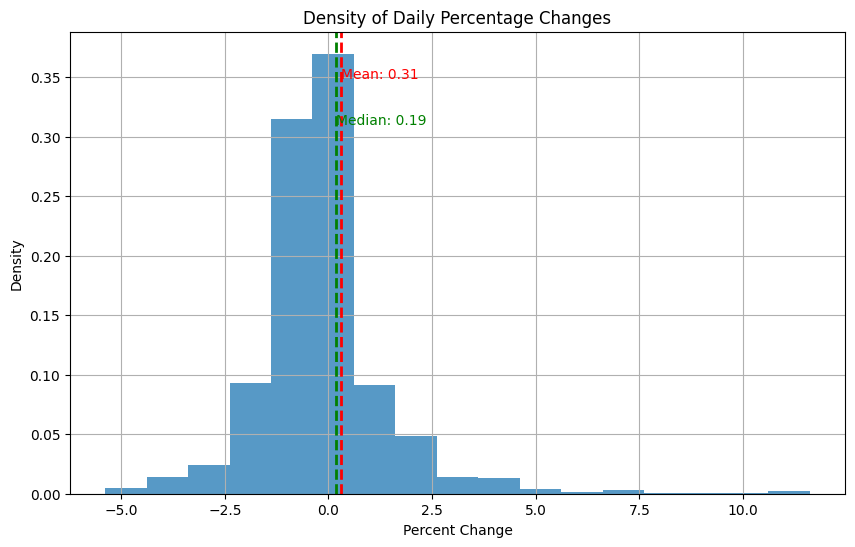

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'cleaned_percent_changes' is defined as before

# Calculate the median of percent changes
median_percent_change = np.median(cleaned_percent_changes)

# 1. Determine Bin Edges
bin_width = 1  # Adjusted bin width to 1 for this example
min_change = cleaned_percent_changes.min()
max_change = cleaned_percent_changes.max()
bins = np.arange(min_change, max_change + bin_width, bin_width)

# 2. Compute Histogram
counts, bin_edges = np.histogram(cleaned_percent_changes, bins=bins)

# 3. Convert Counts to Density
total_counts = counts.sum()
bin_widths = np.diff(bin_edges)
density = counts / (total_counts * bin_widths)

# 4. Store Density Information in a DataFrame
density_df = pd.DataFrame({'Bin Edge Start': bin_edges[:-1], 'Density': density})

# Plotting the density manually
plt.figure(figsize=(10, 6))
plt.bar(density_df['Bin Edge Start'], density_df['Density'], width=bin_width, alpha=0.75)
plt.title('Density of Daily Percentage Changes')
plt.xlabel('Percent Change')
plt.ylabel('Density')
plt.grid(True)

# Add a line for the mean
plt.axvline(mean_percent_change, color='r', linestyle='dashed', linewidth=2)
plt.text(mean_percent_change, plt.ylim()[1] * 0.9, f'Mean: {mean_percent_change:.2f}', color='r')

# Add a line for the median
plt.axvline(median_percent_change, color='g', linestyle='dashed', linewidth=2)
plt.text(median_percent_change, plt.ylim()[1] * 0.8, f'Median: {median_percent_change:.2f}', color='g')

plt.show()
